In [3]:
from   GD1_funcs    import *
import mw_transform as     mw
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# initial positions in cartesian coordinates in natural units
xi,yi,zi = np.array([3.41,13.00,9.58]) # (kpc) in physical units (same as Koposov 2010)
                                       #  with x sign flipped
# initial velocities in cartesian coordinates in natural units
vxi,vyi,vzi = np.array([200.4,-162.6,13.9]) # (km/s) in physical units

# initial coordinates in cylindrical coordinates
Ri,zcyli,phii = xyz_to_cyl(xi,yi,zi) # phi is in radians

# initial velocities in cylindrical coordinates
vri,vti,vzcyli = vxvyvz_to_vrvtvz(xi,yi,zi,vxi,vyi,vzi)

ts   = 1000 # number of timesteps
time = np.linspace(0.,1e1,ts)

phi1_pos,phi2_pos,phi2_err = table2_kop2010()
phi1_dist,dist,dist_err    = table3_kop2010()
phi1_vrad,Vrad,V_err       = table1_kop2010()
phi1_mu,mu1,mu2,sigma_mu   = table4_kop2010()


x_err_pos  = np.ones(len(phi1_pos))
x_err_dist = np.ones(len(phi1_dist))
x_err_vrad = np.ones(len(phi1_vrad))
x_err_mu   = np.ones(len(phi1_mu))


In [6]:
def contour_singlebox(Vc,q):
    ro = 8.5
    vo = Vc
    p  = potential.LogarithmicHaloPotential(q=q,normalize=1)
    o    = Orbit(vxvv=[Ri/ro,vri/vo,vti/vo,zcyli/ro,vzcyli/vo,phii],ro=ro,vo=vo)
    o.integrate(time,p)
    
    # Orbit in Galactic coordinates
    lval = o.ll(time,ro = ro,obs= [ro,0.,0.])
    bval = o.bb(time,ro = ro,obs= [ro,0.,0.])
    
    
    pmll = o.pmll(time, ro = ro, obs=[ro,0.,0.,0.,vo,0.])
    pmbb = o.pmbb(time, ro = ro, obs=[ro,0.,0.,0.,vo,0.])

    galpy_vel  = mw.pmllpmbb_to_pmphi12(pmll,pmbb,lval,bval,degree=True)
    vrad_galpy = o.vlos(time)
    

    phi12 = mw.lb_to_phi12(lval,bval,degree=True)
    phi12[phi12[:,0] > 180,0]-= 360.



    L_pos  = likelihood_all(phi12[:,0],phi1_pos,x_err_pos,phi12[:,1],phi2_pos,phi2_err,time)
    L_dist = likelihood_all(phi12[:,0],phi1_dist,x_err_dist,o.dist(time),dist,dist_err,time)
    L_vrad = likelihood_all(phi12[:,0],phi1_vrad,x_err_vrad,vrad_galpy,Vrad,V_err,time)
    L_mu1  = likelihood_all(phi12[:,0],phi1_mu,x_err_mu,galpy_vel.T[0],mu1,sigma_mu,time)
    L_mu2  = likelihood_all(phi12[:,0],phi1_mu,x_err_mu,galpy_vel.T[1],mu2,sigma_mu,time)
    L_total = L_pos + L_dist + L_vrad + L_mu1 + L_mu2
    return L_total

In [9]:
Vc_list = np.linspace(160.,300.,30)
q_list  = np.linspace(0.4,1.6,30)


table = np.zeros([len(Vc_list),len(q_list)])

for i in range(len(Vc_list)):
    #print i
    for j in range(len(q_list)):
        table[j][i] = contour_singlebox(Vc_list[i],q_list[j])


<matplotlib.colorbar.Colorbar instance at 0x109030f38>

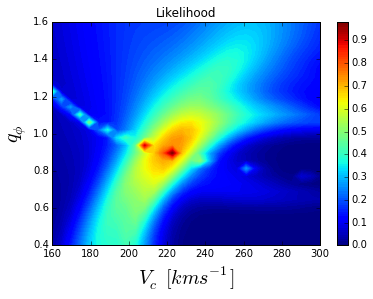

In [8]:
plt.ion()
plt.contourf(Vc_list,q_list,table,100)
plt.xlabel("$V_c \, [kms^{-1}]$",fontsize=20)
plt.ylabel("$q_{\phi}$",fontsize=20)
plt.title("Likelihood")
plt.colorbar()